# Hands-On 5: Basic Hybrid Application MPI+OpenMP

This Hands-on comprises 2 session. Next table shows the documents and
files needed to develop in the exercises.

|  Sessions      | Codes                  | files              | 
| -------------- | -----------------------| ------------------ |
| Session 1      | Hello World            | hello-mpi+openmp.c                             |
| Session 2      | Hybrid Matrix Multiple | mm-mpi.c, mm-openmp.c, and mm-mpi+openmp.c |

First, we will execute a sample hybrid code *Hello World* to understand the meaning of heterogeneous environment applied in Parallel Computing.


##  `Matrix Multiple Benchmarks`

### OpenMP

In [1]:
%%writefile ./material/mm-openmp.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

void writeResultsToFile(int size, double time_spend, int num_threads) {
    FILE *output_file = fopen("./output/mm_openMP.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    } 

    fprintf(output_file, "%d %lf %d ", size, time_spend, num_threads);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void initializeMatrix(int *matrix, int size)
{
  for (int i = 0; i < size; i++)
    for (int j = 0; j < size; j++)
      matrix[i * size + j] = rand() % (10 - 1) * 1;
}

void printMatrix(int *matrix, int size)
{
  for (int i = 0; i < size; i++)
  {
    for (int j = 0; j < size; j++)
      printf("%d\t", matrix[i * size + j]);
    printf("\n");
  }
  printf("\n");
}

int main (int argc, char **argv)
{

 int size = atoi(argv[1]);  
 int i, j, k;
 double t1, t2;

 int  *A = (int *) malloc (sizeof(int)*size*size);
 int  *B = (int *) malloc (sizeof(int)*size*size);
 int  *C = (int *) malloc (sizeof(int)*size*size);

 initializeMatrix(A, size);
 initializeMatrix(B, size);

 t1 = omp_get_wtime();

  int num_threads = 0;

 #pragma omp parallel for private(i, j, k)
  for(i = 0; i < size; i++){
    for(j = 0; j < size; j++){
      for(k = 0; k < size; k++){
        C[i * size + j] += A[i * size + k] * B[k * size + j];
        if(i==0 && j==0 && k == 0)num_threads = omp_get_num_threads();
      }     
    }  
  }
 
 t2 = omp_get_wtime();

//printf("%d\t%f\n",size, t2-t1);

// printMatrix(A,size);
// printMatrix(B,size);
// printMatrix(C,size);

writeResultsToFile(size, t2-t1, num_threads);

 return 0;

}

Overwriting ./material/mm-openmp.c


#### Run the code

In [2]:
!gcc ./material/mm-openmp.c -o ./material/mm -fopenmp

# Performance analysis

In [3]:
%%writefile ./bash/script_mm_openMP.sh
#!/bin/sh

for ((i=2; i<=64; i*=2))
do
  #echo "Number of threads:" $i "=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-="  
  for ((j=200; j<=1000; j+=200))
  do
    OMP_NUM_THREADS="$i" ./material/mm "$j"
  done
  echo 
done

Overwriting ./bash/script_mm_openMP.sh


In [4]:
!rm ./output/mm_mpi.txt
!bash ./bash/script_mm_openMP.sh

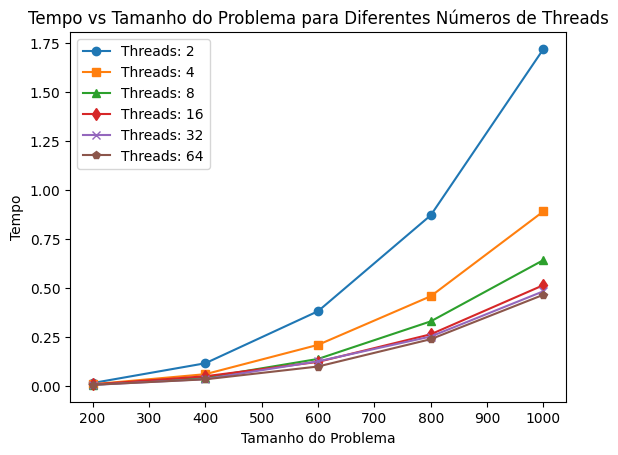

In [5]:
import matplotlib.pyplot as plt

file_name = "./output/mm_openMP.txt"

# Ler o arquivo e armazenar os dados
dados = {}
with open(file_name, 'r') as file:
    for line in file:
        valores = line.split()
        for i in range(0, len(valores), 3):
            tamanho = float(valores[i])
            tempo = float(valores[i + 1])
            threads = float(valores[i + 2])
            if threads in dados:
                dados[threads].append((tamanho, tempo))
            else:
                dados[threads] = [(tamanho, tempo)]

# Opções de estilo para as linhas do gráfico
estilos = ['o-', 's-', '^-', 'd-', 'x-', 'p-', 'h-', '+-']
estilo_idx = 0

# Ordenar os dados e criar o gráfico
for threads, valores in dados.items():
    if estilo_idx >= len(estilos):
        estilo_idx = 0  # Resetar o índice de estilos se tiver mais linhas que estilos disponíveis
    valores.sort(key=lambda x: x[0])  # Ordenar pelo tamanho
    tamanhos = [x[0] for x in valores]
    tempos = [x[1] for x in valores]
    plt.plot(tamanhos, tempos, estilos[estilo_idx], label=f'Threads: {int(threads)}')
    estilo_idx += 1

# Configurar e mostrar o gráfico
plt.xlabel('Tamanho do Problema')
plt.ylabel('Tempo')
plt.title('Tempo vs Tamanho do Problema para Diferentes Números de Threads')
plt.legend()
plt.show()



### MPI

In [6]:
%%writefile ./material/mm-mpi.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <mpi.h>

void writeResultsToFile(int size, double time_spend, int num_processors) {
    FILE *output_file = fopen("./output/mm_mpi.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    } 

    fprintf(output_file, "%d %lf %d ", size, time_spend, num_processors);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void mms(double *a, int fa, int ca, int lda, double *b, int fb, int cb, int ldb, double *c, int fc, int cc, int ldc) {
    int i, j, k;
    double s;
    for (i = 0; i < fa; i++) 
        for (j = 0; j < cb; j++) {
            s = 0.;
            for (k = 0; k < ca; k++)
                s += a[i * lda + k] * b[k * ldb + j];
            c[i * ldc + j] = s;
        }
}

void mm(double *a, int fa, int ca, int lda, double *b, int fb, int cb, int ldb, double *c, int fc, int cc, int ldc, int nodo, int np) {
    int i, j, k;
    double s;
    if (nodo == 0) {
        for (i = 1; i < np; i++)
            MPI_Send(&a[i * lda * fa / np], fa / np * ca, MPI_DOUBLE, i, 20, MPI_COMM_WORLD);
        MPI_Bcast(b, fb * cb, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    } else {
        MPI_Recv(a, fa / np * ca, MPI_DOUBLE, 0, 20, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Bcast(b, fb * cb, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    }
    mms(a, fa / np, ca, lda, b, fb, cb, ldb, c, fc / np, cc, ldc);
    if (nodo == 0)
        for (i = 1; i < np; i++)
            MPI_Recv(&c[i * ldc * fc / np],fc / np * cc, MPI_DOUBLE, i, 30, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    else
        MPI_Send(c, fc / np * cc, MPI_DOUBLE, 0, 30, MPI_COMM_WORLD);
}

/*
c
c initialize - random initialization for array
c
*/

void initialize(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {  
      m[i * ld + j] = (double)(i + j);
    }
  }
}

void initializealea(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {  
      m[i * ld + j] = (double)rand() / RAND_MAX;
    }
  }
}

void escribir(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {  
      printf("%.4lf ",m[i * ld + j]);
    }
    printf("\n");
  }
}

void comparar(double *m1, int fm1, int cm1, int ldm1, double *m2, int fm2, int cm2, int ldm2)
{
  int i, j;

  for(i = 0; i < fm1; i++)
    for(j = 0; j < cm1; j++) {
      if(m1[i * ldm1 + j] != m2[i * ldm2 + j]) {
        printf("Discrepance in %d,%d: %.8lf , %.8lf\n", i, j, m1[i * ldm1 + j], m2[i * ldm2 + j]);
        return;
      }
    }
}

int main(int argc, char *argv[]) {
  int nodo, np, i, j, fa, fal, ca, lda, fb, cb, ldb, fc, fcl, cc, ldc, N;
  int long_name;
  double ti, tf;
  double *a, *b, *c, *c0;
  char    nombre_procesador[MPI_MAX_PROCESSOR_NAME];
  MPI_Status estado;
 
  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &nodo);
  MPI_Get_processor_name(nombre_procesador, &long_name);

  if (nodo == 0) {
    N = atoi(argv[1]);
  }
  MPI_Bcast(&N, 1, MPI_INT, 0, MPI_COMM_WORLD);
  
  fa = ca = lda = fb = cb = ldb = fc = cc = ldc = N;
  fal = N / np;
  fcl = N / np;
  if (nodo == 0) {
    a = (double *) malloc(sizeof(double) * fa * ca);
    b = (double *) malloc(sizeof(double) * fb * cb);
    c = (double *) malloc(sizeof(double) * fc * cc);
  } else {
    a = (double *) malloc(sizeof(double) * fal * ca);
    b = (double *) malloc(sizeof(double) * fb * cb);
    c = (double *) malloc(sizeof(double) * fcl * cc);
  }
  
  if (nodo == 0) {
    c0 = (double *) malloc(sizeof(double) * fc * cc);
    initialize(a, fa, ca, lda);
    initialize(b, fb, cb, ldb);

    mms(a, fa, ca, lda, b, fb, cb, ldb, c0, fc, cc, ldc);
  }

  MPI_Barrier(MPI_COMM_WORLD);

  ti = MPI_Wtime();

  mm(a, fa, ca, lda, b, fb, cb, ldb, c, fc, cc, ldc, nodo, np);

  MPI_Barrier(MPI_COMM_WORLD);
  tf = MPI_Wtime();
  if (nodo == 0) {
    printf("(%d) Process %d, %s, Time %.6lf\n", N, np, nombre_procesador, tf - ti);
    //printf("%d\t%f\t%d\n", N, tf - ti, np);
    writeResultsToFile(N, tf - ti, np); 
  }
  
  free(a);
  free(b);
  free(c);
  
  if (nodo == 0)
    free(c0);
  MPI_Finalize();
}

Overwriting ./material/mm-mpi.c


#### Run the code

In [7]:
!mpicc ./material/mm-mpi.c -o ./material/mm-mpi

# Performance Analysis

In [8]:
%%writefile ./bash/script_mm_mpi.sh
#!/bin/sh

for ((i=2; i<=64; i*=2))
do
  #echo "Number of threads:" $i "=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-="  
  for ((j=200; j<=1000; j+=200))
  do
    mpirun -np "$i" ./material/mm-mpi "$j"
  done
  echo 
done

Overwriting ./bash/script_mm_mpi.sh


In [10]:
!rm ./output/mm_openMP.txt
!bash ./bash/script_mm_mpi.sh

(200) Process 2, aquario, Time 0.012973
(400) Process 2, aquario, Time 0.089994
(600) Process 2, aquario, Time 0.293295
(800) Process 2, aquario, Time 0.707869
(1000) Process 2, aquario, Time 1.383595

(200) Process 4, aquario, Time 0.007715
(400) Process 4, aquario, Time 0.048099
(600) Process 4, aquario, Time 0.155285
(800) Process 4, aquario, Time 0.369381
(1000) Process 4, aquario, Time 0.721285

(200) Process 8, aquario, Time 0.006177
(400) Process 8, aquario, Time 0.035865
(600) Process 8, aquario, Time 0.107081
(800) Process 8, aquario, Time 0.282452
(1000) Process 8, aquario, Time 0.555669

(200) Process 16, aquario, Time 0.179960
(400) Process 16, aquario, Time 0.474011
(600) Process 16, aquario, Time 0.533180
(800) Process 16, aquario, Time 0.614852
(1000) Process 16, aquario, Time 0.857121

(200) Process 32, aquario, Time 0.396013
(400) Process 32, aquario, Time 0.660005
(600) Process 32, aquario, Time 2.318349
(800) Process 32, aquario, Time 2.360303
(1000) Process 32, aqua

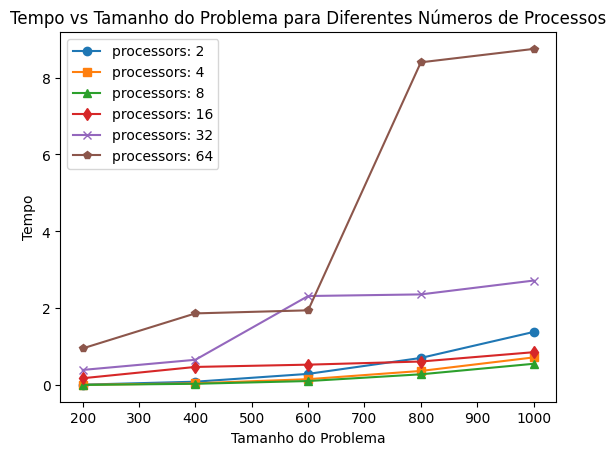

In [11]:
import matplotlib.pyplot as plt

file_name = "./output/mm_mpi.txt"

# Ler o arquivo e armazenar os dados
dados = {}
with open(file_name, 'r') as file:
    for line in file:
        valores = line.split()
        for i in range(0, len(valores), 3):
            tamanho = float(valores[i])
            tempo = float(valores[i + 1])
            processors = float(valores[i + 2])
            if processors in dados:
                dados[processors].append((tamanho, tempo))
            else:
                dados[processors] = [(tamanho, tempo)]

# Opções de estilo para as linhas do gráfico
estilos = ['o-', 's-', '^-', 'd-', 'x-', 'p-', 'h-', '+-']
estilo_idx = 0

# Ordenar os dados e criar o gráfico
for processors, valores in dados.items():
    if estilo_idx >= len(estilos):
        estilo_idx = 0  # Resetar o índice de estilos se tiver mais linhas que estilos disponíveis
    valores.sort(key=lambda x: x[0])  # Ordenar pelo tamanho
    tamanhos = [x[0] for x in valores]
    tempos = [x[1] for x in valores]
    plt.plot(tamanhos, tempos, estilos[estilo_idx], label=f'processors: {int(processors)}')
    estilo_idx += 1

# Configurar e mostrar o gráfico
plt.xlabel('Tamanho do Problema')
plt.ylabel('Tempo')
plt.title('Tempo vs Tamanho do Problema para Diferentes Números de Processos')
plt.legend()
plt.show()



### MPI + OpenMP

In [2]:
%%writefile ./material/mm-mpi_openmp.c

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <mpi.h>
#include <omp.h>

void writeResultsToFile(int size, double time_spend, int num_processors, int num_threads) {
    FILE *output_file = fopen("./output/mm-mpi_openmp.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    } 

    fprintf(output_file, "%d %lf %d %d ", size, time_spend, num_threads, num_processors);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void mm(double *a, int fa,int ca,int lda,double *b,int fb,int cb,int ldb,double *c,int fc,int cc,int ldc,int nodo,char *maquina)
{
  int i, j, k;
  double s;

 #pragma omp parallel 
 {
   #pragma omp for private(i,j,k,s) schedule(static)
    for (i = 0; i < fa; i++) 
    {
     for(j=0;j<cb;j++)
     {
      s=0.;
      for (k = 0; k < ca; k++)
      s = s+a[i*lda+k]*b[k*ldb+j];
      c[i*ldc+j]=s;
     }
    }
   }
  }

/*
c
c initialize - random initialization for array
c
*/

void initialize(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {  
      m[i*ld+j] = (double)(i+j);
    }
  }
}

void initializealea(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {  
      m[i*ld+j] = (double)rand()/RAND_MAX;
    }
  }
    
}

void escribir(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {  
      printf("%.4lf ",m[i*ld+j]);
    }
    printf("\n");
  }
    
}
/*
c
c     mseconds - returns elapsed milliseconds since Jan 1st, 1970.
c
*/
long long mseconds(){
  struct timeval t;
  gettimeofday(&t, NULL);
  return t.tv_sec*1000 + t.tv_usec/1000;
}

void comparar(double *m1,int fm1,int cm1,int ldm1,double *m2,int fm2,int cm2,int ldm2)
{
  int i,j;

  for(i=0;i<fm1;i++)
    for(j=0;j<cm1;j++)
    {
      if(m1[i*ldm1+j]!=m2[i*ldm2+j])
      {
        printf("Discrepance in %d,%d: %.8lf , %.8lf\n",i,j,m1[i*ldm1+j],m2[i*ldm2+j]);
        return;
      }
    }
    
}

int main(int argc,char *argv[]) 
{
  int nodo,np,i, j,fa,fal,ca,lda,fb,cb,ldb,fc,fcl,cc,ldc,N,NUMTHREADS;
  int long_name;
  double ti,tf;
  double *a,*b,*c,*c0;
  char    nombre_procesador[MPI_MAX_PROCESSOR_NAME];
  MPI_Status estado;
 
  MPI_Init(&argc,&argv);
  MPI_Comm_size(MPI_COMM_WORLD,&np);
  MPI_Comm_rank(MPI_COMM_WORLD,&nodo);
  MPI_Get_processor_name(nombre_procesador,&long_name);

  if(nodo==0)
  {
    N=atoi(argv[1]);
    NUMTHREADS=atoi(argv[2]);
  }
    
  MPI_Bcast(&N,1,MPI_INT,0,MPI_COMM_WORLD);
  MPI_Bcast(&NUMTHREADS,1,MPI_INT,0,MPI_COMM_WORLD);
  omp_set_num_threads(NUMTHREADS);
  
  fa=ca=lda=fb=cb=ldb=fc=cc=ldc=N;
  fal=N/np;
  fcl=N/np;
  if(nodo==0)
  {
    a = (double *) malloc(sizeof(double)*fa*ca);
    b = (double *) malloc(sizeof(double)*fb*cb);
    c = (double *) malloc(sizeof(double)*fc*cc);
  }
  else
  {
    a = (double *) malloc(sizeof(double)*fal*ca);
    b = (double *) malloc(sizeof(double)*fb*cb);
    c = (double *) malloc(sizeof(double)*fcl*cc);
  }
  
  if(nodo==0)
  {
    c0=(double *) malloc(sizeof(double)*fc*cc);
    initialize(a,fa,ca,lda);
    for(i=1;i<np;i++)
    {
      MPI_Send(&a[i*lda*N/np],fal*ca,MPI_DOUBLE,i,20,MPI_COMM_WORLD);
    }
    initialize(b,fb,cb,ldb);
    MPI_Bcast(b,fb*cb,MPI_DOUBLE,0,MPI_COMM_WORLD);
    mm(a,fa,ca,lda,b,fb,cb,ldb,c0,fc,cc,ldc,nodo,nombre_procesador);
  }
  else
  {
    MPI_Recv(a,fal*ca,MPI_DOUBLE,0,20,MPI_COMM_WORLD,&estado);
    MPI_Bcast(b,fb*cb,MPI_DOUBLE,0,MPI_COMM_WORLD);
  } 

  MPI_Barrier(MPI_COMM_WORLD);

  ti=MPI_Wtime();

  mm(a,fal,ca,lda,b,fb,cb,ldb,c,fcl,cc,ldc,nodo,nombre_procesador);

  MPI_Barrier(MPI_COMM_WORLD);
  tf=MPI_Wtime();
  if(nodo==0)
  {
   printf("(%d) Threads %d, Process %d, %s, Time %.6lf\n\n",N, NUMTHREADS, np, nombre_procesador,tf-ti);
    writeResultsToFile(N, tf-ti, np, NUMTHREADS);

    //printf("%d\t%f\n", N, tf-ti);
    for(i=1;i<np;i++)
    {
      MPI_Recv(&c[i*ldc*N/np],fcl*cc,MPI_DOUBLE,i,30,MPI_COMM_WORLD,&estado);
    }
  }
  else
  {
    MPI_Send(c,fcl*cc,MPI_DOUBLE,0,30,MPI_COMM_WORLD);
  } 
  
  free(a);
  free(b);
  free(c);
  if(nodo==0)
    free(c0);
  MPI_Finalize();
}

Overwriting ./material/mm-mpi_openmp.c


#### Run the Code

In [3]:
!mpicc ./material/mm-mpi_openmp.c -o ./material/mm-mpi_openmp -fopenmp

In [4]:
%%writefile ./bash/mm-mpi_openmp.sh
#!/bin/sh

for ((i=2; i<=64; i*=2)) # num_threads
do
    for ((j=2; j<=8; j*=2)) # num_processors
    do
        for ((k=200; k<=1000; k+=200))
        do
            mpirun -np "$j" ./material/mm-mpi_openmp  "$k" "$i" 
        done
    done
done

Overwriting ./bash/mm-mpi_openmp.sh


In [6]:
!rm ./output/mm-mpi_openmp.txt
!bash ./bash/mm-mpi_openmp.sh

(200) Threads 2, Process 2, aquario, Time 0.005592

(400) Threads 2, Process 2, aquario, Time 0.044718

(600) Threads 2, Process 2, aquario, Time 0.149586

(800) Threads 2, Process 2, aquario, Time 0.360065

(1000) Threads 2, Process 2, aquario, Time 0.701360

(200) Threads 2, Process 4, aquario, Time 0.004511

(400) Threads 2, Process 4, aquario, Time 0.027841

(600) Threads 2, Process 4, aquario, Time 0.096210

(800) Threads 2, Process 4, aquario, Time 0.241752

(1000) Threads 2, Process 4, aquario, Time 0.463992

(200) Threads 2, Process 8, aquario, Time 0.011361

(400) Threads 2, Process 8, aquario, Time 0.042208

(600) Threads 2, Process 8, aquario, Time 0.085745

(800) Threads 2, Process 8, aquario, Time 0.229241

(1000) Threads 2, Process 8, aquario, Time 0.432894

(200) Threads 4, Process 2, aquario, Time 0.003568

(400) Threads 4, Process 2, aquario, Time 0.027191

(600) Threads 4, Process 2, aquario, Time 0.092387

(800) Threads 4, Process 2, aquario, Time 0.248284

(1000) Th

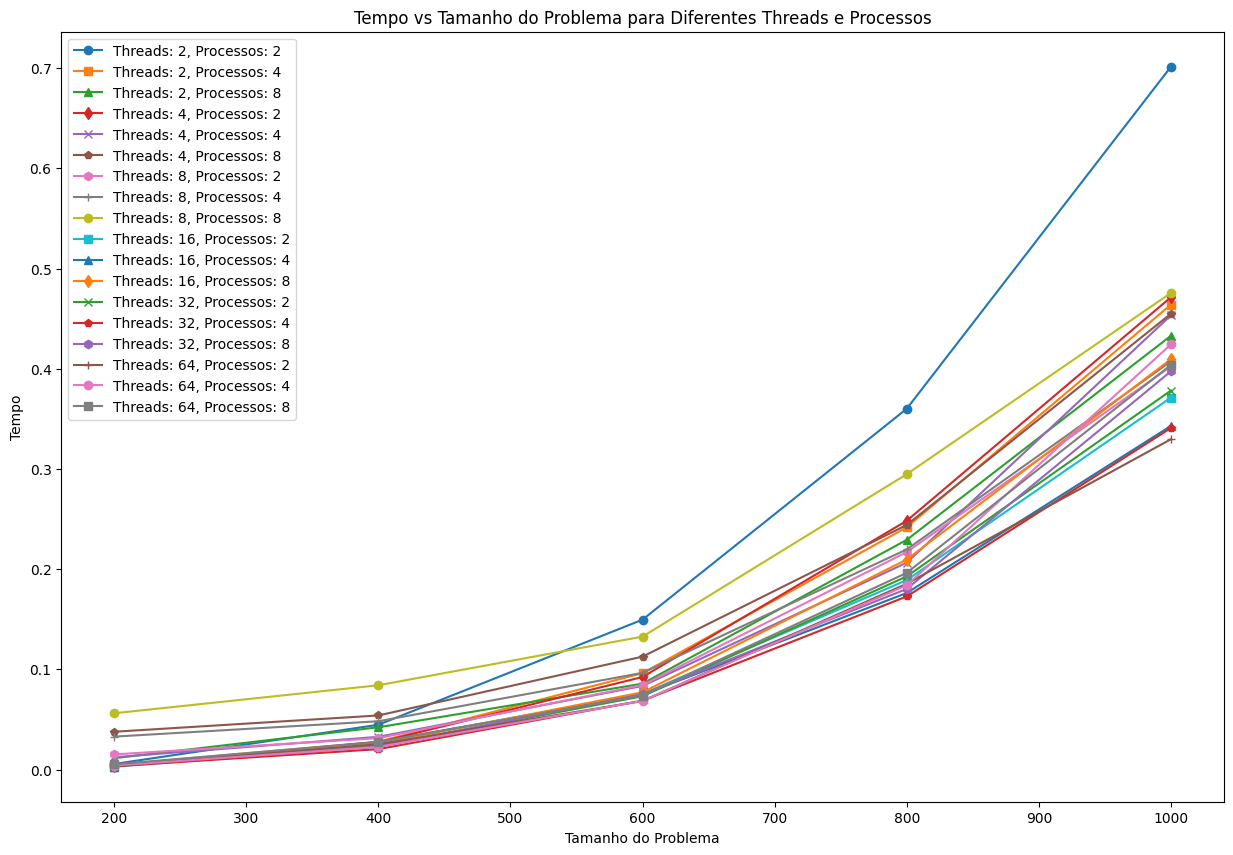

In [7]:
import matplotlib.pyplot as plt

file_name = "./output/mm-mpi_openmp.txt"

# Ler o arquivo e armazenar os dados
dados = {}
with open(file_name, 'r') as file:
    for line in file:
        valores = line.split()
        for i in range(0, len(valores), 4):
            tamanho = float(valores[i])
            tempo = float(valores[i + 1])
            threads = float(valores[i + 2])
            processos = float(valores[i + 3])
            chave = (threads, processos)
            if chave in dados:
                dados[chave].append((tamanho, tempo))
            else:
                dados[chave] = [(tamanho, tempo)]

# Opções de estilo para as linhas do gráfico
estilos = ['o-', 's-', '^-', 'd-', 'x-', 'p-', 'h-', '+-']
estilo_idx = 0

# Configurar o tamanho da figura
plt.figure(figsize=(15, 10))

# Ordenar os dados e criar o gráfico
for (threads, processos), valores in dados.items():
    if estilo_idx >= len(estilos):
        estilo_idx = 0  # Resetar o índice de estilos se tiver mais linhas que estilos disponíveis
    valores.sort(key=lambda x: x[0])  # Ordenar pelo tamanho
    tamanhos = [x[0] for x in valores]
    tempos = [x[1] for x in valores]
    plt.plot(tamanhos, tempos, estilos[estilo_idx], label=f'Threads: {int(threads)}, Processos: {int(processos)}')
    estilo_idx += 1

# Configurar e mostrar o gráfico
plt.xlabel('Tamanho do Problema')
plt.ylabel('Tempo')
plt.title('Tempo vs Tamanho do Problema para Diferentes Threads e Processos')
plt.legend()
plt.show()


## Practice with the Benchmarks

From the parallelized matrix multiplication codes (MPI (`mm-mpi.c`), OpenMP (`mm-openmp.c)` and Hybrid (`mm-mpi+openmp.c`). Make the following plots:

-   Execution time
-   Speedup

They are comparatively commenting on the performance of the optimizations of each code, with each group doing the experimentation on a specific execution platform.

## References

M. Boratto. *Hands-On Supercomputing with Parallel Computing*.
Available:
<https://github.com/muriloboratto/Hands-On-Supercomputing-with-Parallel-Computing>.
2022.

Forum, Message Passing Interface. *MPI: A Message-Passing Interface
Standard*. University of Tennessee, 1994, USA.

B. Chapman, G. Jost and R. Pas. *Using OpenMP: Portable Shared Memory
Parallel Programming*. The MIT Press, 2007, USA.